In [ ]:
# !pip install networkx
# !pip install tqdm
# !pip install pydot

In [86]:
import os
from collections import defaultdict
import math
import networkx as nx 
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from __future__ import annotations

In [3]:
tf.__version__

'2.5.0'

# Data setup

In [6]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip")
ZipFile("movielens.zip",'r').extractall()

# Read downloaded files

In [110]:
movies = pd.read_csv("./ml-latest-small/movies.csv")
movies['movieId'] = movies['movieId'].apply(lambda x: f'movie_{x}')
movies.head(1)

,movieId,title,genres
0,movie_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [111]:
ratings = pd.read_csv("./ml-latest-small/ratings.csv")
ratings["rating"] = ratings["rating"].astype(float)
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")

In [112]:
print("Movies data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


In [113]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,movie_1,4.0,964982703
1,1,movie_3,4.0,964981247
2,1,movie_6,4.0,964982224
3,1,movie_47,5.0,964983815
4,1,movie_50,5.0,964982931


In [114]:
movies.head()

,movieId,title,genres
0,movie_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,movie_2,Jumanji (1995),Adventure|Children|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,movie_5,Father of the Bride Part II (1995),Comedy


# Utils function

In [115]:
def get_movie_title_by_id(movieId) -> Movie[str]:
    return movies[movies['movieId']== movieId]['title'].to_list()[0]

def get_movie_id_by_title(title) -> Movie[str]:
    return movies[movies['title']== title]['movieId'].tolist()[0]

print(get_movie_id_by_title("Waiting to Exhale (1995)"))
print(get_movie_title_by_id("movie_100"))


movie_4
City Hall (1996)


# Construct movie graph

## Step 1: create the weighted edges between movies

In [116]:
min_rating = 5
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

rated_movies = ratings[ratings.rating >= min_rating]
movies_grouped_by_users = list(rated_movies.groupby('userId'))
# idea: group by userId then count movie appearance and pair (movie_x, movie_y) appearance

for group in tqdm(movies_grouped_by_users, position=0, leave=True, desc="Computing movie rating feature"):
    # group: Tuple(userId, List[movieId])
    movie_list = group[1]['movieId'].tolist()
    for i in range(len(movie_list)):
        item_frequency[movie_list[i]] += 1
        for j in range(i+1, len(movie_list)):
            m_1 = min(movie_list[i], movie_list[j]) # min("movie_1","movie_2") => "movie_1"
            m_2 = max(movie_list[i], movie_list[j]) 
            pair_frequency[(m_1, m_2)] += 1
            
    

Computing movie rating feature: 100%|██████████| 573/573 [00:00<00:00, 806.27it/s]


## Step 2: Create the graph with the nodes and edges

In [117]:
min_weight = 10
D = math.log(sum(item_frequency.values()))

# Create the movie undirected graph
movies_graph = nx.Graph()
# Add weighted edges between movies
# This automatic add nodes to the graph
for pair in tqdm(pair_frequency.keys(), position=0, leave=True, desc="Creating movie graph"):
    x,y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    pmi = math.log(xy_frequency) \
        - math.log(x_frequency) \
        - math.log(y_frequency) \
        + D
    weight = pmi * xy_frequency
    # Only include edge with weight >= min_weight
    if weight >= min_weight:
        movies_graph.add_edge(x, y, weight=weight)
    
    

Creating movie graph: 100%|██████████| 298586/298586 [00:00<00:00, 422653.96it/s]


In [118]:
print("total node:", movies_graph.number_of_nodes())
print("total edge:", movies_graph.number_of_edges())

total node: 1405
total edge: 40043


In [119]:
degrees = [movies_graph.degree[node] for node in movies_graph.nodes]
print("Mean degree:", np.mean(degrees))

Mean degree: 57.00071174377224


## Step 3: Create vocabulary and a mapping from tokens to integer indices

In [120]:
vocabulary = ["NA"] + list(movies_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

In [121]:
vocabulary_lookup["movie_10"]

299

# Implement the biased random walk

A random walk starts from a given node, and randomly picks a neighbour node to move to. If the edges are weighted, the neighbour is selected probabilistically with respect to weights of the edges between the current node and its neighbours. This procedure is repeated for num_steps to generate a sequence of related nodes.

The biased random walk balances between breadth-first sampling (where only local neighbours are visited) and depth-first sampling (where distant neighbours are visited) by introducing the following two parameters:

* Return parameter (p): Controls the likelihood of immediately revisiting a node in the walk. Setting it to a high value encourages moderate exploration, while setting it to a low value would keep the walk local.
* In-out parameter (q): Allows the search to differentiate between inward and outward nodes. Setting it to a high value biases the random walk towards local nodes, while setting it to a low value biases the walk to visit nodes which are further away.


In [126]:
def next_step(graph: Graph, previous: str, current:str, p: float, q: float) -> Node[str]: 
    neighbors = list(graph.neighbors(current)) # get neighbor nodes and their weights 
    weights = []
    for neighbor in neighbors:
        if neighbor == previous:
            # p mean the return parameter - control the probability to the previous node
            weights.append(graph[current][previous]["weight"] / p)
        elif graph.has_edge(neighbor, previous):
            # control the probability of visiting the local node
            weights.append(graph[current][neighbor]["weight"])
        else:
            # q mean the in-out parameter - control the probability to move forward
            weights.append(graph[current][neighbor]["weight"] / q)
    weight_sum = sum(weights)
    # probability of each neighbor node
    probabilities = [w/weight_sum for w in weights]
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next

def biased_random_walk(graph: Graph, num_walks: int, num_steps: int, p: float, q: float) -> List[Node[str]]:
    walks = []
    nodes = list(graph.nodes())
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)
        for node in tqdm(nodes, position=0, leave=True, desc=f"Biased random walks iteration {walk_iteration}"):
            walk = [node]
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                next_node = next_step(graph=graph, previous=previous, current=current, p=p, q=q)
                walk.append(next_node)
            walk = [vocabulary_lookup[token] for token in walk]
            walks.append(walk)
    return walks

# Generate training data using the biased random walk

In [127]:
p = 1
q = 1
num_walks = 5
num_steps = 10
walks = biased_random_walk(
    graph=movies_graph, 
    num_walks=num_walks,
    num_steps=num_steps,
    p=p,
    q=q
    )
print("Number of walks generate (n.o_node * num_walk):", len(walks))

Biased random walks iteration 4: 100%|██████████| 1405/1405 [00:06<00:00, 208.06it/s]

Number of walks generate (n.o_node * num_walk): 7025


# Generate positive and negative examples from training data
* Training skip-gram model:
* Description:
    * target: a movie in a walk sequence
    * context: another movie in a walk sequence
    * weight: how many times these two movies occur in walk sequences
    * label: 
        * 1 if these two movie(target and context) are samples from the walk sequences
        * 0 otherwise (if randomly sampled)

In [129]:
def generate_examples(sequences: List[Node], window_size: int, num_negative_samples: float, vocabulary_size: int) -> List:
    example_weights = defaultdict(int)
    for sequence in tqdm(sequences, position=0, leave=True, desc="Generating positive and negative samples"):
        pairs, lables = keras.preprocessing.sequence.skipgrams(
            sequence, 
            vocabulary_size = vocabulary_size,
            window_size = window_size,
            negative_samples = num_negative_samples                                                   
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = lables[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target==context:
                continue # ignore same pair
            entry = (target, context, label)
            example_weights[entry] += 1
    
    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights.keys():
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)
    return np.array(targets), np.array(contexts), np.array(labels), np.array((weights))

num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary)
    )


Generating positive and negative samples: 100%|██████████| 7025/7025 [00:14<00:00, 480.12it/s]


In [130]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

Targets shape: (884479,)
Contexts shape: (884479,)
Labels shape: (884479,)
Weights shape: (884479,)


# Convert numpy array into tensorflow dataset

In [131]:
def create_dataset(targets: List[int], contexts: List[int], labels: List[int], weights: List[int], batch_size: int) -> Dataset:
    inputs = {
        "target": targets,
        "context": contexts
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size*2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset
batch_size = 1024
dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size
    )

# Train skip-gram model
Our skip-gram is a simple binary classification model that works as follows:

1. An embedding is looked up for the target movie.
2. An embedding is looked up for the context movie.
3. The dot product is computed between these two embeddings.
4. The result (after a sigmoid activation) is compared to the label.
5. A binary crossentropy loss is used

In [132]:
learning_rate = 0.001
embedding_dim = 50
num_epochs = 10

In [133]:
def create_model(vocabulary_size, embedding_dim):
    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # init item embedding
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer= keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    target_embeddings = embed_item(inputs["target"])
    context_embeddings = embed_item(inputs["context"])
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")([target_embeddings, context_embeddings])
    model = keras.Model(inputs= inputs, outputs= logits)
    
    return model
    

# Train the model

In [134]:
model = create_model(vocabulary_size=len(vocabulary), embedding_dim=embedding_dim)
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=learning_rate),
    loss= keras.losses.BinaryCrossentropy(from_logits=True),
)

In [135]:
keras.utils.plot_model(
    model, show_shapes= True, show_dtype= True, show_layer_names= True
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [136]:
history = model.fit(dataset, epochs= num_epochs)

Epoch 1/10
863/863 [==============================] - 5s 6ms/step - loss: 2.4465
Epoch 2/10
863/863 [==============================] - 5s 6ms/step - loss: 2.3350
Epoch 3/10
863/863 [==============================] - 5s 6ms/step - loss: 2.3266
Epoch 4/10
863/863 [==============================] - 5s 6ms/step - loss: 2.3231
Epoch 5/10
863/863 [==============================] - 5s 6ms/step - loss: 2.3197
Epoch 6/10
863/863 [==============================] - 5s 6ms/step - loss: 2.3154
Epoch 7/10
863/863 [==============================] - 5s 6ms/step - loss: 2.3114
Epoch 8/10
863/863 [==============================] - 5s 6ms/step - loss: 2.3082
Epoch 9/10
863/863 [==============================] - 5s 6ms/step - loss: 2.3052
Epoch 10/10
863/863 [==============================] - 5s 6ms/step - loss: 2.3025


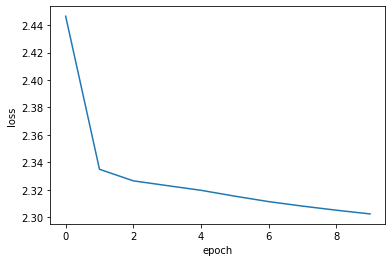

In [137]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

# Get embedding 

In [138]:
movie_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print("movie embedding:", movie_embeddings.shape)

movie embedding: (1406, 50)


In [139]:
query_movies = [
    "Toy Story (1995)",
    "Jumanji (1995)",
]

In [140]:
query_embeddings = []
for movie in query_movies:
    movie_id = get_movie_id_by_title(movie)
    token_id = vocabulary_lookup[movie_id]
    movie_embed = movie_embeddings[token_id]
    query_embeddings.append(movie_embed)
query_embeddings = np.array(query_embeddings)    

In [142]:
similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(movie_embeddings),
    transpose_b=True
)
_, indices = tf.math.top_k(similarities, k= 5)
indices = indices.numpy().tolist()

In [147]:
for idx, title in enumerate(query_movies):
    print(title)
    print("".rjust(len(title),"-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_movieId = vocabulary[token]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}")
    print()

Toy Story (1995)
----------------
- Lion King, The (1994)
- Toy Story (1995)
- Beauty and the Beast (1991)
- Aladdin (1992)
- Braveheart (1995)

Jumanji (1995)
--------------
- Ghost (1990)
- Jumanji (1995)
- Cliffhanger (1993)
- Crimson Tide (1995)
- Firm, The (1993)



# Saving learnt embeddings

In [148]:
import io

out_v = io.open("embeddings.tsv", "w", encoding="utf-8")
out_m = io.open("metadata.tsv", "w", encoding="utf-8")

for idx, movie_id in enumerate(vocabulary[1:]):
    movie_title = list(movies[movies.movieId == movie_id].title)[0]
    vector = movie_embeddings[idx]
    out_v.write("\t".join([str(x) for x in vector]) + "\n")
    out_m.write(movie_title + "\n")

out_v.close()
out_m.close()